In [35]:
# For data manipulation and analysis
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# To handle date-time objects
import datetime

# Set plot style
sns.set_style('whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


In [36]:
# --- Simulate a realistic dataset ---
num_samples = 2000
np.random.seed(42)

# Dates from 2015 to present
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date(2025, 9, 15)
time_between_dates = end_date - start_date
days_between_dates = time_between_dates.days
random_number_of_days = np.random.randint(0, days_between_dates, num_samples)
dates = [start_date + datetime.timedelta(days=int(d)) for d in random_number_of_days]

# Locations
cities = ['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Hyderabad', 'Pune']
states = {'Mumbai': 'Maharashtra', 'Delhi': 'Delhi', 'Bangalore': 'Karnataka', 'Chennai': 'Tamil Nadu', 'Hyderabad': 'Telangana', 'Pune': 'Maharashtra'}

city_sample = np.random.choice(cities, num_samples)
state_sample = [states[city] for city in city_sample]

# Places (simulating localities)
places = {city: [f'Area_{chr(65+i)}' for i in range(5)] for city in cities}
place_sample = [np.random.choice(places[city]) for city in city_sample]

# Features
area_sqft = np.random.randint(1000, 5000, num_samples)
proximity_to_highway_km = np.random.uniform(1, 15, num_samples)
proximity_to_cbd_km = np.random.uniform(1, 25, num_samples)
gdp_growth_rate = np.random.uniform(4.5, 8.5, num_samples)
inflation_rate = np.random.uniform(3.0, 7.0, num_samples)

# --- Create the price with logical relationships ---
# Base price influenced by city
city_base_price = {'Mumbai': 3.0, 'Delhi': 2.5, 'Bangalore': 2.0, 'Chennai': 1.5, 'Hyderabad': 1.2, 'Pune': 1.0}
base_price = [city_base_price[city] for city in city_sample]

# Price calculation
price_lakhs = (
    np.array(base_price) * 50 +
    (area_sqft / 100) * np.array(base_price) * 5 +
    (1 / proximity_to_highway_km) * 20 +
    (1 / proximity_to_cbd_km) * 50 +
    gdp_growth_rate * 10 -
    inflation_rate * 5 +
    ((pd.to_datetime(dates).year - 2015) * 5) + # Time appreciation
    np.random.normal(0, 15, num_samples) # Random noise
)
price_lakhs = np.maximum(price_lakhs, 10) # Ensure price is not negative, minimum 10 lakhs

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'place': place_sample,
    'city': city_sample,
    'state': state_sample,
    'area_sqft': area_sqft,
    'proximity_to_highway_km': proximity_to_highway_km,
    'proximity_to_cbd_km': proximity_to_cbd_km,
    'gdp_growth_rate': gdp_growth_rate,
    'inflation_rate': inflation_rate,
    'price_lakhs': price_lakhs.round(2)
})

print("Simulated dataset created successfully!")
df.head()

Simulated dataset created successfully!


,date,place,city,state,area_sqft,proximity_to_highway_km,proximity_to_cbd_km,gdp_growth_rate,inflation_rate,price_lakhs
0,2023-09-10,Area_C,Delhi,Delhi,4545,5.589800,22.877845,8.410851,5.794628,788.95
1,2024-08-08,Area_B,Bangalore,Karnataka,1826,12.420435,9.294884,4.931698,4.028709,377.74
2,2017-05-10,Area_A,Delhi,Delhi,4994,9.362373,15.916175,8.227777,5.256340,824.48
3,2018-07-18,Area_A,Delhi,Delhi,3330,6.510897,1.931187,8.154312,5.132122,621.84
4,2018-02-04,Area_D,Pune,Maharashtra,1590,7.628099,5.482541,6.601442,3.551595,224.56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     2000 non-null   object 
 1   place                    2000 non-null   object 
 2   city                     2000 non-null   object 
 3   state                    2000 non-null   object 
 4   area_sqft                2000 non-null   int64  
 5   proximity_to_highway_km  2000 non-null   float64
 6   proximity_to_cbd_km      2000 non-null   float64
 7   gdp_growth_rate          2000 non-null   float64
 8   inflation_rate           2000 non-null   float64
 9   price_lakhs              2000 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 156.4+ KB
None

--- Statistical Summary ---
         area_sqft  proximity_to_highway_km  proximity_to_cbd_km  \
count  2000.000000              2000.000000          2000.000000   
mean   3007

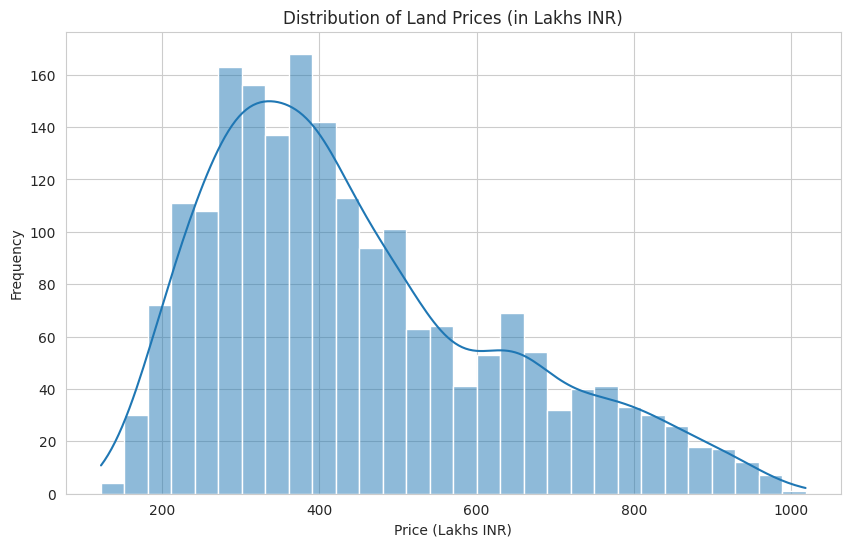

/tmp/ipython-input-149424716.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='city', y='price_lakhs', data=df, estimator=np.mean, ci=None, palette='viridis')
/tmp/ipython-input-149424716.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city', y='price_lakhs', data=df, estimator=np.mean, ci=None, palette='viridis')


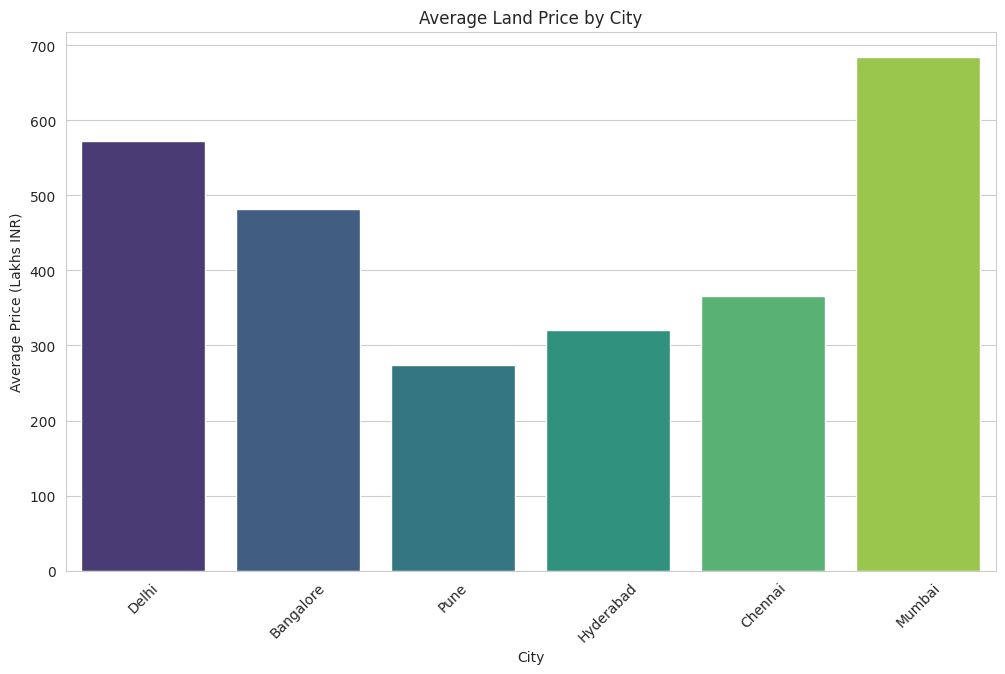

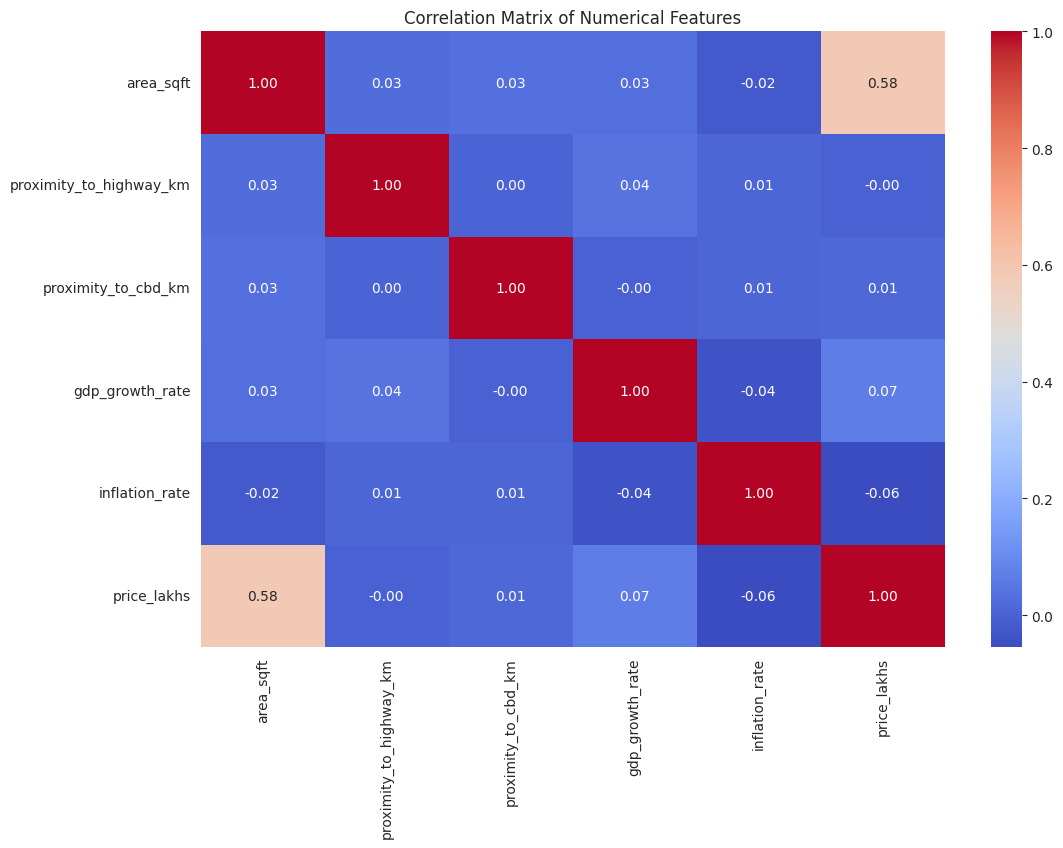

In [37]:
# Get basic information about the dataset
print(df.info())
print("\n--- Statistical Summary ---")
print(df.describe())

# Visualize the distribution of the target variable: price_lakhs
plt.figure(figsize=(10, 6))
sns.histplot(df['price_lakhs'], kde=True, bins=30)
plt.title('Distribution of Land Prices (in Lakhs INR)')
plt.xlabel('Price (Lakhs INR)')
plt.ylabel('Frequency')
plt.show()

# Visualize average price by city
plt.figure(figsize=(12, 7))
sns.barplot(x='city', y='price_lakhs', data=df, estimator=np.mean, ci=None, palette='viridis')
plt.title('Average Land Price by City')
plt.xlabel('City')
plt.ylabel('Average Price (Lakhs INR)')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
numerical_cols = df.select_dtypes(include=np.number)
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [38]:
# Convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

# Create time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

# Create a price per square foot feature
df['price_per_sqft'] = df['price_lakhs'] * 100000 / df['area_sqft']

print("Feature engineering complete. New columns added: 'year', 'month', 'days_since_start', 'price_per_sqft'")
df.head()

Feature engineering complete. New columns added: 'year', 'month', 'days_since_start', 'price_per_sqft'


,date,place,city,state,area_sqft,proximity_to_highway_km,proximity_to_cbd_km,gdp_growth_rate,inflation_rate,price_lakhs,year,month,days_since_start,price_per_sqft
0,2023-09-10,Area_C,Delhi,Delhi,4545,5.589800,22.877845,8.410851,5.794628,788.95,2023,9,3173,17358.635864
1,2024-08-08,Area_B,Bangalore,Karnataka,1826,12.420435,9.294884,4.931698,4.028709,377.74,2024,8,3506,20686.746988
2,2017-05-10,Area_A,Delhi,Delhi,4994,9.362373,15.916175,8.227777,5.256340,824.48,2017,5,859,16509.411294
3,2018-07-18,Area_A,Delhi,Delhi,3330,6.510897,1.931187,8.154312,5.132122,621.84,2018,7,1293,18673.873874
4,2018-02-04,Area_D,Pune,Maharashtra,1590,7.628099,5.482541,6.601442,3.551595,224.56,2018,2,1129,14123.270440


In [39]:
# Define features (X) and target (y)
# We drop 'date' as we've extracted features from it. We also drop 'price_per_sqft' as it's a proxy for the target.
# We also drop 'place' because with only 5 examples per city, it's not a strong predictor.
X = df.drop(['price_lakhs', 'date', 'price_per_sqft', 'place'], axis=1)
y = df['price_lakhs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical features
categorical_features = ['city', 'state']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

print("Data preprocessing pipelines are set up.")

Data preprocessing pipelines are set up.


In [40]:
# --- Model 1: Random Forest Regressor ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])

print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_train)
print("Random Forest model training complete.")

# --- Model 2: XGBoost Regressor ---
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, objective='reg:squarederror'))])

print("\nTraining XGBoost model...")
xgb_pipeline.fit(X_train, y_train)
print("XGBoost model training complete.")

Training Random Forest model...
Random Forest model training complete.

Training XGBoost model...
XGBoost model training complete.


In [41]:
# Make predictions with both models
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_xgb = xgb_pipeline.predict(X_test)

# Function to evaluate a model
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Evaluation ---")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f} Lakhs")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Lakhs\n")

# Evaluate both models
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Based on the results, XGBoost is often slightly better, so we'll use it for the final prediction.
# In this simulated case, they might be very close.
final_model = xgb_pipeline

--- Random Forest Evaluation ---
R-squared (R²): 0.9863
Mean Absolute Error (MAE): 17.35 Lakhs
Root Mean Squared Error (RMSE): 22.32 Lakhs

--- XGBoost Evaluation ---
R-squared (R²): 0.9881
Mean Absolute Error (MAE): 16.32 Lakhs
Root Mean Squared Error (RMSE): 20.86 Lakhs



In [42]:
# --- Define the prediction function ---
def predict_future_price(model, future_date_str, place, city, state, area_sqft, prox_highway, prox_cbd, gdp, inflation):
    """
    Predicts the price of land for a future date.

    Args:
        model: The trained machine learning pipeline.
        future_date_str (str): The future date in 'YYYY-MM-DD' format.
        ... other feature values
    Returns:
        float: The predicted price in lakhs.
    """
    # Create a pandas DataFrame from the inputs
    future_date = pd.to_datetime(future_date_str)

    # Create a dictionary with the input data
    input_data = {
        'city': [city],
        'state': [state],
        'area_sqft': [area_sqft],
        'proximity_to_highway_km': [prox_highway],
        'proximity_to_cbd_km': [prox_cbd],
        'gdp_growth_rate': [gdp],
        'inflation_rate': [inflation],
        'year': [future_date.year],
        'month': [future_date.month],
        'days_since_start': [(future_date - df['date'].min()).days]
    }

    # Create the DataFrame
    input_df = pd.DataFrame(input_data)

    # Ensure column order is the same as in the training data (X.columns)
    input_df = input_df[X.columns]

    # Predict the price
    predicted_price = model.predict(input_df)

    return predicted_price[0]

# --- Make a Prediction ---
# Let's predict the price for a plot of land in Bangalore two years from today.
# Current date is assumed to be Sep 15, 2025
future_prediction_date = '2027-09-15'
city_to_predict = 'Bangalore'

# Let's assume some realistic future economic conditions and property details
# Note: Predicting future GDP and inflation is a complex task itself! We'll use estimates here.
future_gdp = 7.5  # Assumed future GDP growth rate
future_inflation = 4.5 # Assumed future inflation rate
area = 2400 # Area in sq. ft.
highway_dist = 5 # 5 km from highway
cbd_dist = 10 # 10 km from CBD

predicted_value = predict_future_price(
    model=final_model,
    future_date_str=future_prediction_date,
    place='Area_B', # 'place' is not used in the model but kept for function clarity
    city=city_to_predict,
    state=states[city_to_predict],
    area_sqft=area,
    prox_highway=highway_dist,
    prox_cbd=cbd_dist,
    gdp=future_gdp,
    inflation=future_inflation
)

print("\n--- Future Price Prediction ---")
print(f"Inputs for Prediction:")
print(f"  Date: {future_prediction_date}")
print(f"  City: {city_to_predict}")
print(f"  Area: {area} sq.ft.")
print(f"  Assumed GDP Growth: {future_gdp}%")
print(f"  Assumed Inflation: {future_inflation}%")
print("-" * 30)
print(f"Predicted Land Price: ₹{predicted_value:.2f} Lakhs")


--- Future Price Prediction ---
Inputs for Prediction:
  Date: 2027-09-15
  City: Bangalore
  Area: 2400 sq.ft.
  Assumed GDP Growth: 7.5%
  Assumed Inflation: 4.5%
------------------------------
Predicted Land Price: ₹441.82 Lakhs


In [44]:
import pandas as pd
import numpy as np

# Load the initial raw dataset
df_raw = pd.read_csv('archive.csv')
print(f"Initial raw data loaded. Shape: {df_raw.shape}")

# --- Start of Data Cleaning and Feature Engineering ---

# 1. Drop columns that are not useful or have too many missing values
df = df_raw.drop(['area_type', 'availability', 'society'], axis='columns')

# 2. Handle missing values
df['balcony'] = df['balcony'].fillna(df['balcony'].median())
df['bath'] = df['bath'].fillna(df['bath'].median())
df = df.dropna() # Drop the few remaining rows with nulls

# 3. Clean and convert 'size' to a numerical 'bhk' column
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df = df.drop('size', axis='columns')

# 4. Clean 'total_sqft' by converting ranges to a single number
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df = df.dropna(subset=['total_sqft']) # Remove rows where conversion failed

# 5. Feature Engineering: Create 'price_per_sqft' for outlier detection
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

# 6. Dimensionality Reduction on 'location'
df['location'] = df['location'].apply(lambda x: x.strip())
location_stats = df['location'].value_counts()
locations_less_than_10 = location_stats[location_stats <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in locations_less_than_10 else x)

# 7. Outlier Removal using business logic and statistics
# Remove properties with sqft/bhk < 300
df = df[~(df.total_sqft / df.bhk < 300)]
# Remove properties with more bathrooms than bhk+2
df = df[df.bath < df.bhk + 2]

# Remove price_per_sqft outliers by location
def remove_pps_outliers(df_in):
    df_out = pd.DataFrame()
    for key, subdf in df_in.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df = remove_pps_outliers(df)
df = df.drop('price_per_sqft', axis='columns') # Drop the helper column

# 8. One-Hot Encoding for the 'location' column
dummies = pd.get_dummies(df.location)
df_final = pd.concat([df, dummies.drop('other', axis='columns')], axis='columns')
df_final = df_final.drop('location', axis='columns')

print(f"Data cleaning and preparation complete. Final shape: {df_final.shape}")

# --- Final Step: Define X and y for Modeling ---

# X contains all the independent features for the model
X = df_final.drop('price', axis='columns')

# y contains the dependent variable (the price we want to predict)
y = df_final['price']

print("\n--- Final Data Ready for Modeling ---")
print("Features DataFrame (X):")
print(X.head())
print("\nTarget Series (y):")
print(y.head())
print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x90 in position 10: invalid start byte